# Model recovery attack: `news-popularity`

In [7]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mra
from mra import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_csv('../datasets/news-popularity.csv').sample(frac=1)
df = df.drop(columns=["url"])
xy = df.to_numpy()
x = xy[:,0:-1]
y = xy[:,-1].reshape((len(x), 1))
# Normalize by feature to [0,1]
min_values = pd.DataFrame(x).describe().transpose()['min'].to_numpy()
max_values = pd.DataFrame(x).describe().transpose()['max'].to_numpy()
x = (x-min_values)/(max_values-min_values)
y = (y-min(y))/(max(y) - min(y))
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

In [9]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    output = tf.keras.layers.Dense(256, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256, activation="relu")(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, output)

In [10]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.MeanSquaredError(),
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=1000)

Iteration 0001: Training loss: 0.0096
Iteration 1001: Training loss: 0.0000
Iteration 2001: Training loss: 0.0000
Iteration 3001: Training loss: 0.0000
Iteration 4001: Training loss: 0.0003
Iteration 5001: Training loss: 0.0000
Iteration 6001: Training loss: 0.0000


In [11]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(1024, activation=act)(xin)
    x = tf.keras.layers.Dense(512, activation=act)(x)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(59, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [12]:
log_attack = mra.attack(
    attack_iter=100,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.2587, RG-normal: 0.2441, reconstruction validation: 0.0475
Iteration 0002: RG-uniform: 0.2604, RG-normal: 0.2392, reconstruction validation: 0.0474
Iteration 0003: RG-uniform: 0.2674, RG-normal: 0.2388, reconstruction validation: 0.0475
Iteration 0004: RG-uniform: 0.2563, RG-normal: 0.2346, reconstruction validation: 0.0517
Iteration 0005: RG-uniform: 0.2601, RG-normal: 0.2365, reconstruction validation: 0.0478
Iteration 0006: RG-uniform: 0.2708, RG-normal: 0.2440, reconstruction validation: 0.0497
Iteration 0007: RG-uniform: 0.2615, RG-normal: 0.2420, reconstruction validation: 0.0457
Iteration 0008: RG-uniform: 0.2601, RG-normal: 0.2258, reconstruction validation: 0.0459
Iteration 0009: RG-uniform: 0.2593, RG-normal: 0.2336, reconstruction validation: 0.0437
Iteration 0010: RG-uniform: 0.2465, RG-normal: 0.2314, reconstruction validation: 0.0452
Iteration 0011: RG-uniform: 0.2514, RG-normal: 0.2370, reconstruction validation: 0.0422
Iteration 0012: RG-un

In [13]:
np.savetxt('./log/news2.csv', log_attack, delimiter=',')

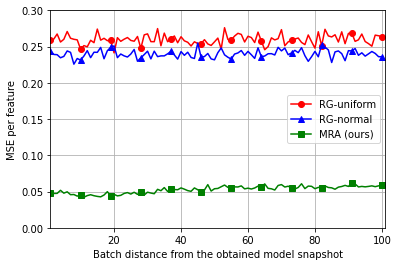

In [29]:
plt.xlim([1,101])
plt.ylim([0,0.3])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(ran, log_attack[:,0], 'ro-', ran, log_attack[:,1], 'b^-', ran, log_attack[:,2], 'gs-', markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'MRA (ours)'], loc='center right')
plt.savefig("fig/news2.pdf", bbox_inches='tight')